In [24]:
import warnings
import pandas as pd
import seaborn as seabornInstance 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings('ignore')

In [25]:
times = [f'time{i}' for i in range(1, 11)]
sites = [f'site{i}' for i in range(1, 11)]
# reading from csv
train_df = pd.read_csv(
    'train_sessions.csv',
    index_col='session_id',
    parse_dates=times
)
test_df = pd.read_csv(
    'test_sessions.csv',
    index_col='session_id',
    parse_dates=times
)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [26]:
idx = train_df.shape[0]
data = train_df                                        # leave train.target for ed
data[sites] = data[sites].fillna(0).astype(np.uint16)  # float->int (55.0 -> 55)

# for each row combine site_ids into one string separated by space
data['words'] = data[sites].astype(np.str).apply(' '.join, axis=1)

# words = CountVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])
words = TfidfVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])

data.drop(['words'], inplace=True, axis=1)
model = LogisticRegression(random_state=17, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)
X_train = words[:idx]
y_train = train_df.target

cv_scores = cross_val_score(model, X_train, y_train, cv=time_split, scoring='roc_auc')
cv_scores, cv_scores.mean()

(array([0.81678381, 0.65515476, 0.87596184, 0.93550758, 0.84744869,
        0.88888981, 0.92493903, 0.87420433, 0.92854015, 0.92308156]),
 0.8670511554896215)

In [27]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  uint16        
 1   time1   253561 non-null  datetime64[ns]
 2   site2   253561 non-null  uint16        
 3   time2   250098 non-null  datetime64[ns]
 4   site3   253561 non-null  uint16        
 5   time3   246919 non-null  datetime64[ns]
 6   site4   253561 non-null  uint16        
 7   time4   244321 non-null  datetime64[ns]
 8   site5   253561 non-null  uint16        
 9   time5   241829 non-null  datetime64[ns]
 10  site6   253561 non-null  uint16        
 11  time6   239495 non-null  datetime64[ns]
 12  site7   253561 non-null  uint16        
 13  time7   237297 non-null  datetime64[ns]
 14  site8   253561 non-null  uint16        
 15  time8   235224 non-null  datetime64[ns]
 16  site9   253561 non-null  uint16        
 17  time9   233084 non-null  

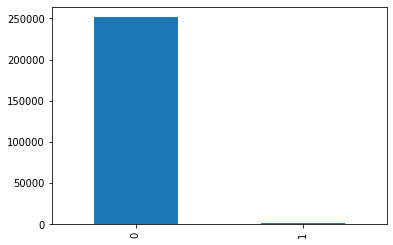

In [28]:
cnt_srs = train_df['target'].value_counts()
cnt_srs.plot.bar(stacked=True);

In [29]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [30]:
# Change site1, ..., site10 columns type 
# to integer and fill NA-values with zeros
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)


In [31]:
# Load websites dictionary
with open(r"site_dic.pkl", "rb") as fh:
    site_ids = pickle.load(fh)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(
    list(site_ids.keys()),
    index=list(site_ids.values()), 
    columns=['site']
)
print(f"{sites_dict.shape[0]=}")
sites_dict.head()

sites_dict.shape[0]=48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [32]:
topAlice = train_df[train_df['target'] == 1]
top_Alice = pd.Series(
    topAlice[sites].values.flatten()
).value_counts().sort_values(ascending=False).head()
sites_dict.loc[top_Alice.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [33]:
# Create a separate dataframe where we will work with timestamps

# Find sessions' starting and ending
# time_df['min'] = train_df[times].min(axis=1, skipna=True)         # option 1
# time_df['max'] = train_df[times].max(axis=1, skipna=True)
# time_df['min'] = train_df[train_df[times].notnull()].max(axis=1)  # option 2
# time_df['min'] = train_df.loc[:, times].min(axis=1, skipna=True)  # option 3
# time_df['min'] = train_df[times].dropna(axis=1).min(axis=1)       # option 4
train_df['min'] = train_df.apply(lambda x: 
    min([int(y.timestamp()) for y in x if isinstance(y, pd.Timestamp)])
, axis=1)
train_df['max'] = train_df[times].apply(lambda x: max(
    [int(y.timestamp()) for y in x if isinstance(y, pd.Timestamp)]
), axis=1)

# Calculate sessions' duration in seconds
train_df['seconds'] = train_df['max'] - train_df['min']
# time_df['seconds'] = (time_df['max'] - time_df['min']).dt.total_seconds()
# time_df.head()
train_df.drop(columns=times).head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target,min,max,seconds
session_id,,,,,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0,0,1357977957,1357977957,0
54843,56,55,56,55,0,0,0,0,0,0,0,1357979843,1357981629,1786
77292,946,946,951,946,946,945,948,784,949,946,0,1357980613,1357980617,4
114021,945,948,949,948,945,946,947,945,946,946,0,1357980617,1357980620,3
146670,947,950,948,947,950,952,946,951,946,947,0,1357980620,1357980622,2


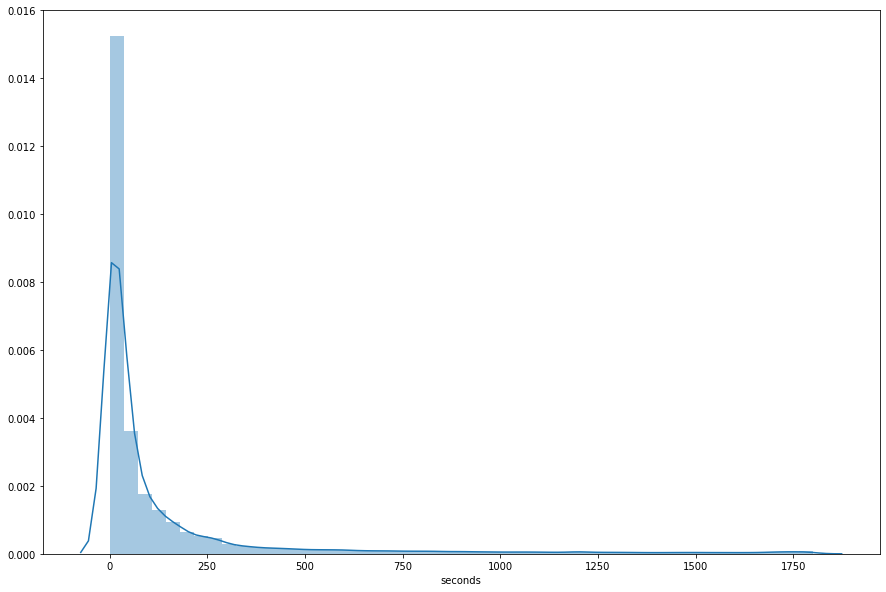

In [34]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(train_df['seconds']);

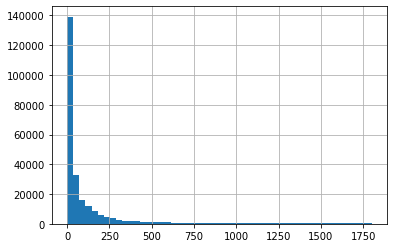

In [35]:
train_df['seconds'].hist(bins=50);

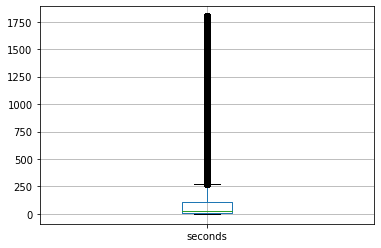

In [36]:
train_df.boxplot(column=['seconds']);

In [37]:
# 1800 - definitely it is "tail"
train_df['seconds'].describe()

count    253561.000000
mean        138.494370
std         295.781742
min           0.000000
25%           7.000000
50%          27.000000
75%         113.000000
max        1800.000000
Name: seconds, dtype: float64

In [38]:
# removing tiles
tails = train_df[train_df['seconds'] > 250].index
train_df_without_tiles = train_df.drop(tails, axis=0)

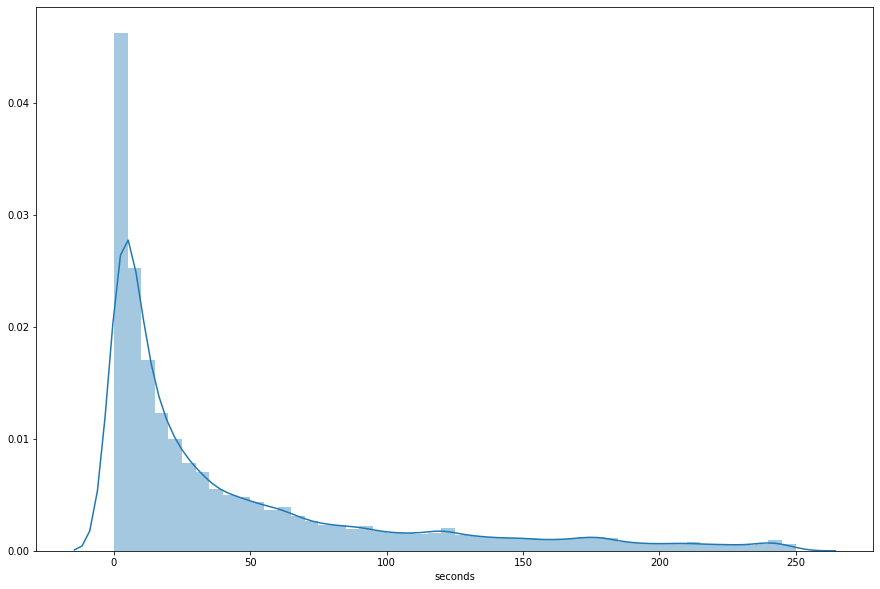

In [39]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(train_df_without_tiles['seconds']);

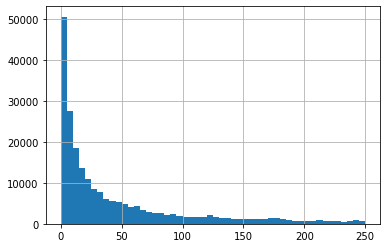

In [40]:
train_df_without_tiles['seconds'].hist(bins=50);

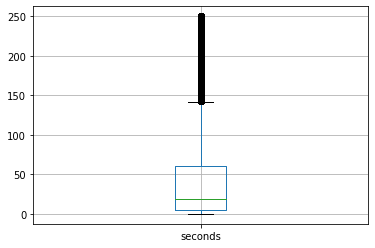

In [41]:
train_df_without_tiles.boxplot(column=['seconds'])

In [42]:
X = train_df_without_tiles[sites + ['seconds']]  # Features
y = train_df_without_tiles['target']  # 1 option                 Target variable
# y = train_df_witout_tiles.target     # 2 option 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=17
)
logreg = LogisticRegression(solver='lbfgs',random_state=0)
logreg.fit(X_train, y_train)
reg_predicted_y = logreg.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, reg_predicted_y)

print(f"ROC AUC {logit_roc_auc}")
#                   Predicted negative   Predicted positive
# Actual negative   True negative(TN)    False positive(FP)      
# Actual positive   False negative(FN)   True positive(TP)
print(f"Confusion Matrix:\n{confusion_matrix(y_test, reg_predicted_y)}\n")
print(f"Classification Report:\n{classification_report(y_test, reg_predicted_y)}")

for x in range(len(reg_predicted_y)):
   if (reg_predicted_y[x] == 1):
      print(x, end="\t")

ROC AUC 0.5
Confusion Matrix:
[[43405     0]
 [  429     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     43405
           1       0.00      0.00      0.00       429

    accuracy                           0.99     43834
   macro avg       0.50      0.50      0.50     43834
weighted avg       0.98      0.99      0.99     43834



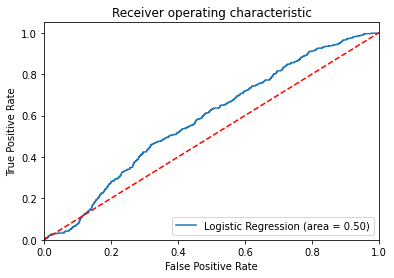

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
tree_predicted_y = decision_tree.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, tree_predicted_y)

print(f"ROC AUC {logit_roc_auc}")
#                   Predicted negative   Predicted positive
# Actual negative   True negative(TN)    False positive(FP)      
# Actual positive   False negative(FN)   True positive(TP)
print(f"Confusion Matrix:\n{confusion_matrix(y_test, tree_predicted_y)}\n")
print(
    f"Classification Report:\n{classification_report(y_test, tree_predicted_y)}"
)
for x in range(len(tree_predicted_y)):
   if (tree_predicted_y[x] == 1):
      print(x, end="\t")

# Additional: display the resulting tree using graphviz.
# You can use pydot or web-service dot2png.
# plot_tree(
#     decision_tree,                        
#     feature_names=train_df_without_tiles.columns,
#     filled=True,                                  # color
#     class_names=["Alice", "Anonimus"]
# );

ROC AUC 0.5944733951300016
Confusion Matrix:
[[42905   500]
 [  343    86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43405
           1       0.15      0.20      0.17       429

    accuracy                           0.98     43834
   macro avg       0.57      0.59      0.58     43834
weighted avg       0.98      0.98      0.98     43834

113	332	348	359	374	375	481	512	564	565	610	786	807	820	868	891	956	1035	1063	1141	1385	1666	1703	1717	1751	1886	1902	1919	1986	2012	2044	2066	2109	2158	2201	2275	2623	2634	2701	2767	2804	3009	3106	3203	3315	3351	3392	3463	3484	3556	3569	3648	3723	3749	3847	3905	3935	4165	4208	4226	4243	4252	4322	4324	4353	4414	4486	4530	4547	4584	4681	4751	4809	4819	4951	4963	4991	4996	5176	5252	5305	5390	5465	5601	5638	5806	5890	5941	6000	6057	6102	6144	6151	6225	6289	6360	6374	6534	6651	6851	6914	6947	7049	7090	7223	7230	7315	7324	7397	7439	7510	7515	7544	7685	7878	7879	7906	8104	

In [ ]:
hosts = pd.read_pickle('../input/site_dic.pkl')
hosts = pd.DataFrame(
    data=list(hosts.keys()),
    index=list(hosts.values()),
    columns=['name']
) # switch key and value
hosts['split'] = hosts['name'].str.split('.') 
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

In [50]:
# The main idea is to consider site_ids as words and sessions
# as sentences of words. This way we can use text processing 
# tools like CountVectorizer and TfidfVectorizer with sessions.
idx = train_df.shape[0]
data[sites] = data[sites].fillna(0).astype(np.uint16)  # float->int (55.0 -> 55)

# for each row combine site_ids into one string separated by space
data['words'] = data[sites].astype(np.str).apply(' '.join, axis=1)
# fit variable->transform
words = CountVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])
# words = TfidfVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])

data.drop(['words'], inplace=True, axis=1)
words

<253561x50000 sparse matrix of type '<class 'numpy.int64'>'
	with 3379553 stored elements in Compressed Sparse Row format>

In [51]:
model = LogisticRegression(random_state=17, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)
X_train = words[:idx]
y_train = train_df.target

cv_scores = cross_val_score(model, X_train, y_train, cv=time_split, scoring='roc_auc')
cv_scores, cv_scores.mean()

(array([0.83141992, 0.64669747, 0.87991757, 0.96315292, 0.84221721,
        0.87840646, 0.94475893, 0.85321988, 0.92987618, 0.90752752]),
 0.8677194063723477)

In [ ]:
# drop_df = train_df.head(15000).drop(times + ['min', 'max', 'seconds', 'target'], axis=1)
# encoded_df = pd.get_dummies(drop_df.astype(str), prefix='', prefix_sep='')
# encoded_df['sum'] = encoded_df[list(encoded_df.columns.values)].sum(axis=1)
# encoded_df['sum'] = (encoded_df.values == '1').sum(axis=1)
# encoded_df['seconds'] = train_df['seconds']
# encoded_df['target'] = train_df['target']
# encoded_df.head()

In [47]:
# features = list(encoded_df.columns.values)
# X = encoded_df[features[:-1]]  # Features
# y = encoded_df['target']                   # Target variable
# 
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2,
#     random_state=17
# )
# decision_tree = DecisionTreeClassifier(max_features=1000, max_depth=10)
# decision_tree.fit(X_train, y_train)
# tree_predicted_y = decision_tree.predict(X_test)
# logit_roc_auc = roc_auc_score(y_test, tree_predicted_y)
# 
# print(f"ROC AUC {logit_roc_auc}")
#                   Predicted negative   Predicted positive
# Actual negative   True negative(TN)    False positive(FP)      
# Actual positive   False negative(FN)   True positive(TP)
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, tree_predicted_y)}\n")
# print(
#     f"Classification Report:\n{classification_report(y_test, tree_predicted_y)}"
# )

In [48]:

# logreg = LogisticRegression(solver='lbfgs',random_state=0)
# logreg.fit(X_train, y_train)
# reg_predicted_y = logreg.predict(X_test)
# logit_roc_auc = roc_auc_score(y_test, reg_predicted_y)
# 
# print(f"ROC AUC {logit_roc_auc}")
# #                   Predicted negative   Predicted positive
# # Actual negative   True negative(TN)    False positive(FP)      
# # Actual positive   False negative(FN)   True positive(TP)
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, reg_predicted_y)}\n")
# print(f"Classification Report:\n{classification_report(y_test, reg_predicted_y)}")


